In [1]:
!pip install tensorflow tensorflow-addons --quiet
# Kaggle has tensorflow pre-installed, no need to pip install anything
import tensorflow as tf
print("[INFO] TensorFlow version:", tf.__version__)



[INFO] TensorFlow version: 2.10.1


In [2]:
from tensorflow.keras import layers, Model
import numpy as np
import math
import tensorflow as tf
# Constants
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = None


In [3]:
dataset_dir = r"C:\Users\Computer\Downloads\archive"

print("[INFO] Loading training dataset (90% split)...")
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    validation_split=0.1,
    subset="training",
    seed=42,
    shuffle=True
)

print("[INFO] Loading validation dataset (10% split)...")
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    validation_split=0.1,
    subset="validation",
    seed=42,
    shuffle=True
)

print("[INFO] Class names detected:")
print(train_dataset.class_names)

NUM_CLASSES = len(train_dataset.class_names)
print("[INFO] Number of classes:", NUM_CLASSES)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)


[INFO] Loading training dataset (90% split)...
Found 326025 files belonging to 500 classes.
Using 293423 files for training.
[INFO] Loading validation dataset (10% split)...
Found 326025 files belonging to 500 classes.
Using 32602 files for validation.
[INFO] Class names detected:
['00500', '00501', '00502', '00503', '00504', '00505', '00506', '00507', '00508', '00509', '00510', '00511', '00512', '00513', '00514', '00515', '00516', '00517', '00518', '00519', '00520', '00521', '00522', '00523', '00524', '00525', '00526', '00527', '00528', '00529', '00530', '00531', '00532', '00533', '00534', '00535', '00536', '00537', '00538', '00539', '00540', '00541', '00542', '00543', '00544', '00545', '00546', '00547', '00548', '00549', '00550', '00551', '00552', '00553', '00554', '00555', '00556', '00557', '00558', '00559', '00560', '00561', '00562', '00563', '00564', '00565', '00566', '00567', '00568', '00569', '00570', '00571', '00572', '00573', '00574', '00575', '00576', '00577', '00578', '00579

[INFO] Visualizing sample batch...


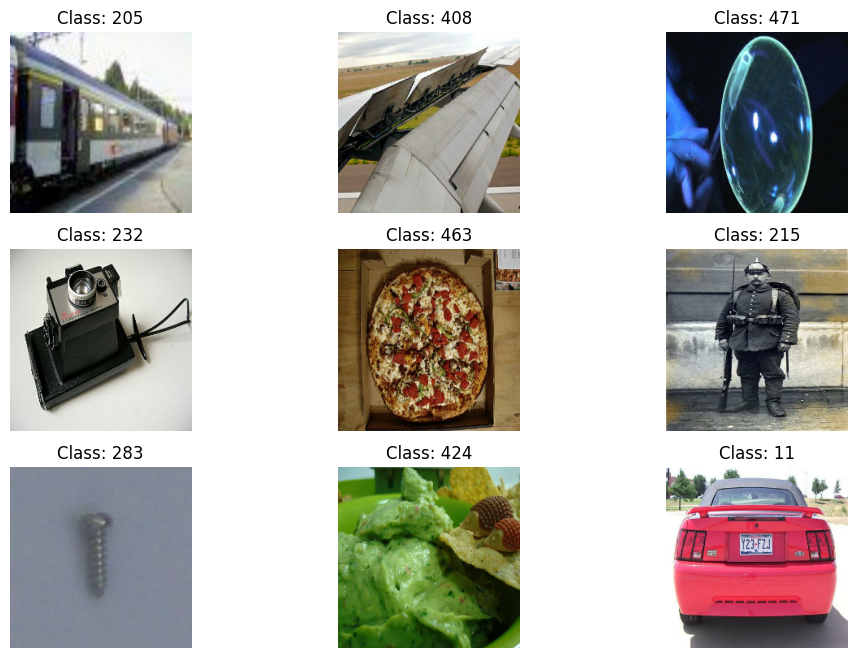

In [4]:
import matplotlib.pyplot as plt

for images, labels in train_dataset.take(1):
    print("[INFO] Visualizing sample batch...")
    plt.figure(figsize=(12, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Class: {labels[i].numpy()}")
        plt.axis("off")


In [5]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1)
])

print("[INFO] Data augmentation pipeline created.")


[INFO] Data augmentation pipeline created.


In [6]:
def augment(images, labels):
    return data_augmentation(images), labels

train_dataset_aug = train_dataset.map(augment, num_parallel_calls=AUTOTUNE)
print("[INFO] Data augmentation applied to training dataset.")


[INFO] Data augmentation applied to training dataset.


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Optional data augmentation (comment out if not needed)
def data_augmentation(x):
    return x  # No augmentation for now

# ✅ Multi-Layer Perceptron block
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# ✅ Serializable custom CLS token prepend layer
@tf.keras.utils.register_keras_serializable(package="VisionTransformer")
class ClassTokenPrepend(layers.Layer):
    def __init__(self, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.projection_dim = projection_dim

    def build(self, input_shape):
        # Trainable CLS token
        self.cls_token_emb = self.add_weight(
            shape=(1, 1, self.projection_dim),
            initializer="zeros",
            trainable=True,
            name="cls_token_emb"
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        cls_tokens = tf.repeat(self.cls_token_emb, repeats=batch_size, axis=0)
        return tf.concat([cls_tokens, inputs], axis=1)

    def get_config(self):
        config = super().get_config()
        config.update({"projection_dim": self.projection_dim})
        return config

# ✅ Vision Transformer model builder
def create_vit_classifier(
    input_shape=(224, 224, 3),
    patch_size=16,
    projection_dim=128,
    transformer_layers=4,
    num_heads=4,
    transformer_units=[256, 128],
    mlp_head_units=[512, 256],
    num_classes=10,
    dropout_rate=0.1
):
    print("[INFO] Creating Vision Transformer model...")
    inputs = layers.Input(shape=input_shape)

    # 1) Data Augmentation (optional)
    x = data_augmentation(inputs)

    # 2) Patch embedding (Conv2D)
    patches = layers.Conv2D(
        filters=projection_dim,
        kernel_size=patch_size,
        strides=patch_size,
        padding="valid"
    )(x)
    seq_len = (input_shape[0] // patch_size) ** 2  # number of patches
    x = layers.Reshape((seq_len, projection_dim))(patches)

    # 3) Prepend CLS token
    x = ClassTokenPrepend(projection_dim)(x)

    # 4) Positional embedding
    pos_emb = layers.Embedding(input_dim=seq_len + 1, output_dim=projection_dim)
    positions = tf.range(start=0, limit=seq_len + 1, delta=1)
    x = x + pos_emb(positions)

    # 5) Transformer Encoder blocks
    for i in range(transformer_layers):
        print(f"[INFO] Adding Transformer layer {i+1}/{transformer_layers}")

        # LayerNorm + MultiHeadAttention
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attn_out = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=projection_dim,
            dropout=dropout_rate
        )(x1, x1)

        # Residual connection
        x2 = layers.Add()([attn_out, x])

        # LayerNorm + MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        mlp_out = mlp(x3, hidden_units=transformer_units, dropout_rate=dropout_rate)

        # Residual connection
        x = layers.Add()([mlp_out, x2])

    # 6) Classification Head
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    cls_token = layers.Lambda(lambda v: v[:, 0, :])(x)  # extract CLS token

    # MLP Head for classification
    cls_token = mlp(cls_token, hidden_units=mlp_head_units, dropout_rate=dropout_rate)
    outputs = layers.Dense(num_classes)(cls_token)

    model = Model(inputs=inputs, outputs=outputs, name="VisionTransformer")
    print("[INFO] Model created successfully!")
    return model

In [8]:
model = create_vit_classifier(
    num_classes=NUM_CLASSES
)
model.summary()


[INFO] Creating Vision Transformer model...
[INFO] Adding Transformer layer 1/4
[INFO] Adding Transformer layer 2/4
[INFO] Adding Transformer layer 3/4
[INFO] Adding Transformer layer 4/4
[INFO] Model created successfully!
Model: "VisionTransformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 128)  98432       ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 196, 128)     0   

In [9]:
initial_lr = 0.0015
warmup_epochs = 10
total_epochs = 50

steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
print(f"[INFO] Steps per epoch: {steps_per_epoch}")

def lrfn(epoch):
    if epoch < warmup_epochs:
        lr = initial_lr * (epoch + 1) / warmup_epochs
    else:
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
        lr = initial_lr * cosine_decay
    print(f"[LR Scheduler] Epoch {epoch+1}: Learning rate = {lr}")
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)


[INFO] Steps per epoch: 9170


In [10]:
print("[INFO] Compiling model...")
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)
print("[INFO] Compilation complete.")


[INFO] Compiling model...
[INFO] Compilation complete.


In [11]:
print("[INFO] Starting training...")
history = model.fit(
    train_dataset_aug,
    validation_data=val_dataset,
    epochs=total_epochs,
    verbose=1,
    callbacks=[lr_schedule]
)
print("[INFO] Training complete.")


[INFO] Starting training...
[LR Scheduler] Epoch 1: Learning rate = 0.00015000000000000001

Epoch 1: LearningRateScheduler setting learning rate to 0.00015000000000000001.
Epoch 1/50
9170/9170 [==============================] - 715s 77ms/step - loss: 5.8176 - accuracy: 0.0204 - val_loss: 5.4863 - val_accuracy: 0.0386 - lr: 1.5000e-04
[LR Scheduler] Epoch 2: Learning rate = 0.00030000000000000003

Epoch 2: LearningRateScheduler setting learning rate to 0.00030000000000000003.
Epoch 2/50
9170/9170 [==============================] - 626s 68ms/step - loss: 5.3358 - accuracy: 0.0510 - val_loss: 5.1169 - val_accuracy: 0.0681 - lr: 3.0000e-04
[LR Scheduler] Epoch 3: Learning rate = 0.00045000000000000004

Epoch 3: LearningRateScheduler setting learning rate to 0.00045000000000000004.
Epoch 3/50
9170/9170 [==============================] - 621s 68ms/step - loss: 5.0964 - accuracy: 0.0716 - val_loss: 4.9421 - val_accuracy: 0.0870 - lr: 4.5000e-04
[LR Scheduler] Epoch 4: Learning rate = 0.000600

In [12]:
print("[INFO] Saving model...")
model.save("vit_model_epoch30.keras")
print("[INFO] Model saved.")


[INFO] Saving model...
[INFO] Model saved.


In [13]:
from tensorflow import keras

model = keras.models.load_model("vit_model_epoch30.keras")

In [14]:
import pickle
# Save history.history (which is a dict) to a .pkl file
with open("training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

print("[INFO] Training history saved as training_history.pkl")

[INFO] Training history saved as training_history.pkl
